In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import os
import pickle
import re
from tensorflow.python.ops import math_ops

## 数据预处理，基础

In [2]:
rating_title = ['UserId' , 'MovieID' , 'Rating' , 'timestamps']
ratings = pd.read_table('data/ratings.dat' , sep='::' , header=None , names=rating_title , engine='python')

users_title = ['UserID' , 'Gender' , 'Age' , 'OccupationID' , 'Zip-code']
users = pd.read_table('data/users.dat' , sep = '::' , header=None , names=users_title , engine='python')

movie_title = ['MovieID' , 'Title' , 'Genres']
movies = pd.read_table('data/movies.dat' , sep='::' , header=None , names=movie_title , engine='python')
users

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


## 数据处理的部分

UserID、Occupation和MovieID不用变。

Gender字段：需要将'F'和'M'转换成0和1。

Age字段：要转成7个连续数字0~6,初始数据就是表示范围的。

Genres字段：是分类字段，要转成数字。首先将Genres中的类别转成字符串到数字的字典，然后再将每个电影的Genres字段
转成数字列表，因为有些电影是多个Genres的组合。

Title字段：处理方式跟Genres字段一样，首先创建文本到数字的字典，然后将Title中的描述转成数字的列表。另外Title中的年份也需要去掉。

Genres和Title字段需要将长度统一，这样在神经网络中方便处理。空白部分用‘< PAD >’对应的数字填充。

In [3]:
# 读取数据，并且对数据进行预处理
def load_data():
    # 读取用户数据
    users_title = ['UserID' , 'Gender' , 'Age' , 'JobID' , 'Zip-code'] # 设置表格标题
    users = pd.read_table("data/users.dat",sep = '::',header=None,names=users_title,engine='python') # 读取数据到表格中
    users = users.filter(regex = 'UserID|Gender|Age|JobID')  # 按照列进行过滤，只保留这 4 列
    users_origin = users.values  # 把 users的值保存这个副本
    
    # 对用户性别进行处理
    gender_map = {'F':0 , 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)  # 对每个元素F和M进行0，1的map映射
    
    # 对用户年龄进行处理，将分散的年龄字段映射成连续的数字
    age_map = {val:i for i,val in enumerate(set(users['Age']))} # 之所以用 set是因为去除重复
    users['Age'] = users['Age'].map(age_map)   # Age的value 部分是 0-6
    
    # 读取电影数据
    movie_title = ['MovieID' , 'Title' , 'Genres']
    movies = pd.read_table('data/movies.dat',sep='::',header=None,names=movie_title,engine='python')
    movies_origin = movies.values  # 把 movies的值保存这个副本
    # 把 Title中的年份去掉
    pattern = re.compile(r'^(.*)\((\d+)\)$')
    # 得到标题字段中的所有单词与序号的字典
    title_map = {val:pattern.match(val).group(1) for i,val in enumerate(set(movies['Title']))}
    # 将每个标题中的单词序列转换呈数字序列
    movies['Title'] = movies['Title'].map(title_map)
    
    # 电影类型转为数字的set
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val) # 修改当前集合，把val包含的元素全部加入到 genres_set中且去除重复
    
    # 长度统一，空白部分用 '<PAD>'填充
    genres_set.add('<PAD>')
    # 将电影类型的 set改为 map  value部分是电影类型所对应的 int
    genres2int = {val:i for i , val in enumerate(genres_set)}
    
    #最右侧循环是取得每条电影数据的电影风格字段值，中间循环是将每个电影风格字段值拆开，因为一部电影有多种风格
    # 下面得到的是一个 map, key 是 电影类型（可以组合），value是个List，表示电影类型的 数字组合
    genres_map = {val:[genres2int[row] for row in val.split('|')] for i,val in enumerate(set(movies['Genres']))}

    
    #将电影类型转成等长数字列表，长度是18，因为一共18种电影，对长度不够的填充<PAD>
    for key in genres_map:
        for cnt in range(max(genres2int.values()) - len(genres_map[key])):
            genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])
    
    movies['Genres'] = movies['Genres'].map(genres_map)
    
    # 电影标题转数字字典
    title_set = set()
    for val in movies['Title'].str.split():   # 没有参数，按照空格换行符制表符等分割
        title_set.update(val)
    title_set.add('<PAD>')
    title2int = {val:i for i , val in enumerate(title_set)}  # 生成电影标题与序号的字典
    
    #将电影标题 Title转为等长的数字列表，长度为15，做法跟电影类型的处理相同
    title_count = 15
    # key是电影Title，value 是电影Title分割出来的词的int 表示
    title_map = {val:[title2int[row] for row in val.split()] for i,val in enumerate(set(movies['Title']))}
    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
    # 这样就把原先 movies['Title']改为了 List[int]表示
    movies['Title'] = movies['Title'].map(title_map) 
    
    
    # 读取评分数据集
    ratings_title = ['UserID' , 'MovieID' , 'ratings' , 'timestamps']
    ratings = pd.read_table('data/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
    ratings = ratings.filter(regex='UserID|MovieID|ratings')
    
    # 合并三个表
    data = pd.merge(pd.merge(ratings , users) , movies)
    
    #将数据分成X和y两张表
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_origin, users_origin    

    

In [4]:
users

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


### 加载数据，并且保存到本地

title_count：Title字段的长度（15）
title_set：Title文本的集合，保存的是各个电影Title拆分后的词
genres2int：电影类型转数字的字典，保存的也是词
features：是输入X,是除了 ratings的其他部分的数据
targets_values：是学习目标y，也就是 ratings的数据
ratings：评分数据集的Pandas对象
users：用户数据集的Pandas对象
movies：电影数据的Pandas对象
data：三个数据集组合在一起的Pandas对象
movies_orig：没有做数据处理的原始电影数据
users_orig：没有做数据处理的原始用户数据

In [5]:
# 序列化对象，并将结果数据流写入到文件对象中
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = load_data()
# 保存在本地
pickle.dump((title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig), open('data/preprocess.p', 'wb'))

In [6]:
users.head(5)

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [7]:
movies.head(5)

,MovieID,Title,Genres
0,1,"[4390, 1995, 3528, 3528, 3528, 3528, 3528, 352...","[1, 11, 15, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9..."
1,2,"[1889, 3528, 3528, 3528, 3528, 3528, 3528, 352...","[18, 11, 13, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
2,3,"[356, 4198, 1008, 3528, 3528, 3528, 3528, 3528...","[15, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9..."
3,4,"[622, 1291, 4805, 3528, 3528, 3528, 3528, 3528...","[15, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,..."
4,5,"[3522, 4295, 173, 2743, 2782, 4641, 3528, 3528...","[15, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,..."


In [8]:
movies.values[0]

array([1,
       list([4390, 1995, 3528, 3528, 3528, 3528, 3528, 3528, 3528, 3528, 3528, 3528, 3528, 3528, 3528]),
       list([1, 11, 15, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])],
      dtype=object)

## 从本地读取进行了特征工程后的数据

In [9]:
# 从本地读取数据
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = pickle.load(open('data/preprocess.p', mode='rb'))

## 搭建网络
### 辅助函数

In [10]:
import tensorflow as tf
import os 
import pickle

def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', mode='rb'))

## 编码实现

In [11]:
# 嵌入矩阵的维度
embed_dim = 32
# 用户ID个数,take()是ndarray的方法，第1个参数的列，第二个参数是axis，表示得到列中对应的各个行组成的 ndarray
uid_max = max(features.take(0,1)) + 1 # 6040
# 性别个数
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
#年龄类别个数
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
#职业个数
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21

#电影ID个数
movie_id_max = max(features.take(1,1)) + 1 # 3952
#电影类型个数
movie_categories_max = max(genres2int.values()) + 1 # 18 + 1 = 19
#电影名单词个数
movie_title_max = len(title_set) # 5216

#对电影类型嵌入向量做加和操作的标志，考虑过使用mean做平均，但是没实现mean
combiner = "sum"

#电影名长度
sentences_size = title_count # = 15
#文本卷积滑动窗口，分别滑动2, 3, 4, 5个单词
window_sizes = {2, 3, 4, 5}
#文本卷积核数量
filter_num = 8

#电影ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

### 超参数

In [12]:
# 训练次数
num_epochs = 5
# 批量大小
batch_size = 256
# 丢弃率
dropout_keep = 0.5
# 学习率
learning_rate = 0.0001
# 每处理N个批量数据显示一次统计信息
show_every_n_batches = 20
# 训练好的模型文件存放位置
save_dir = './save'

### 定义输入占位符

In [13]:
def get_inputs():
    # 用户id
    uid = tf.placeholder(tf.int32, [None, 1], name="uid")
    # 性别
    user_gender = tf.placeholder(tf.int32, [None, 1], name="user_gender")
    # 年龄
    user_age = tf.placeholder(tf.int32, [None, 1], name="user_age")
    # 职业
    user_job = tf.placeholder(tf.int32, [None, 1], name="user_job")
    # 电影id
    movie_id = tf.placeholder(tf.int32, [None, 1], name="movie_id")
    # 电影类型
    movie_categories = tf.placeholder(tf.int32, [None, 18], name="movie_categories")
    # 电影标题
    movie_titles = tf.placeholder(tf.int32, [None, 15], name="movie_titles")
    # 学习目标，就是评分
    targets = tf.placeholder(tf.int32, [None, 1], name="targets")
    # 学习率
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    # 丢弃率
    dropout_keep_prob = tf.placeholder(tf.float32, name = "dropout_keep_prob")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, LearningRate, dropout_keep_prob

## 构建神经网络
### 定义User的嵌入矩阵

In [14]:
def get_user_embedding(uid, user_gender, user_age, user_job):
    with tf.name_scope("user_embedding"):   # 经过这个就少了很多列了
        # 定义用户id的嵌入矩阵，（id总数，32），填入均匀的随机数
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_max, embed_dim], -1, 1), name = "uid_embed_matrix")
        # 经过嵌入层
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, name = "uid_embed_layer")
        # 定义性别的嵌入矩阵，（2，16），填入均匀的随机数
        gender_embed_matrix = tf.Variable(tf.random_uniform([gender_max, embed_dim // 2], -1, 1), name= "gender_embed_matrix")
        # 经过嵌入层
        gender_embed_layer = tf.nn.embedding_lookup(gender_embed_matrix, user_gender, name = "gender_embed_layer")
        # 定义年龄的嵌入矩阵，（7，16），填入均匀的随机数
        age_embed_matrix = tf.Variable(tf.random_uniform([age_max, embed_dim // 2], -1, 1), name="age_embed_matrix")
        # 经过嵌入层
        age_embed_layer = tf.nn.embedding_lookup(age_embed_matrix, user_age, name="age_embed_layer")
        # 定义职业的嵌入矩阵，（21，16），填入均匀的随机数
        job_embed_matrix = tf.Variable(tf.random_uniform([job_max, embed_dim // 2], -1, 1), name = "job_embed_matrix")
        # 经过嵌入层
        job_embed_layer = tf.nn.embedding_lookup(job_embed_matrix, user_job, name = "job_embed_layer")
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

### 将User的嵌入矩阵一起全连接生成 User 的特征

In [15]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    with tf.name_scope("user_fc"):
        #第一层全连接，将用户id、性别、年龄和职业的嵌入向量传给全连接层，输出维度为32
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, name = "uid_fc_layer", activation=tf.nn.relu)
        gender_fc_layer = tf.layers.dense(gender_embed_layer, embed_dim, name = "gender_fc_layer", activation=tf.nn.relu)
        age_fc_layer = tf.layers.dense(age_embed_layer, embed_dim, name ="age_fc_layer", activation=tf.nn.relu)
        job_fc_layer = tf.layers.dense(job_embed_layer, embed_dim, name = "job_fc_layer", activation=tf.nn.relu)
        #第二层全连接,首先将第一层全连接层的输出连接在一起，4*32=128，（1，128），再次传给全连接层，输出维度是（1，200）
        # fully_connected默认是relu函数，dense那个默认是线性函数，但是上面我们设置成了relu函数，这两个函数都是全连接层的意思
        user_combine_layer = tf.concat([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
        user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])
    return user_combine_layer, user_combine_layer_flat

### 定义Movie ID的嵌入矩阵

In [16]:
def get_movie_id_embed_layer(movie_id):
    with tf.name_scope("movie_embedding"):
        # 定义电影id的嵌入矩阵，（3952，32），填入均匀的随机数
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_max, embed_dim], -1, 1), name = "movie_id_embed_matrix")
        # 经过嵌入层
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, movie_id, name = "movie_id_embed_layer")
    return movie_id_embed_layer

### 对电影类型的多个嵌入向量做加和

In [17]:
def get_movie_categories_layers(movie_categories):
    with tf.name_scope("movie_categories_layers"):
        # 定义电影类型的嵌入矩阵，（19，32），填入均匀的随机数
        movie_categories_embed_matrix = tf.Variable(tf.random_uniform([movie_categories_max, embed_dim], -1, 1), name = "movie_categories_embed_matrix")
        # 经过嵌入层
        movie_categories_embed_layer = tf.nn.embedding_lookup(movie_categories_embed_matrix, movie_categories, name = "movie_categories_embed_layer")
        if combiner == "sum":
            # axis=1就是按行求和，有几行结果就有几个元素，可以理解为数据压缩
            movie_categories_embed_layer = tf.reduce_sum(movie_categories_embed_layer, axis=1, keep_dims=True)
#         elif combiner == "mean":
#             movie_categories_embed_layer = tf.reduce_mean(movie_categories_embed_layer, axis=1, keep_dims=True)
    

    return movie_categories_embed_layer

### Movie Title的文本卷积网络实现

In [18]:
def get_movie_cnn_layer(movie_titles):
    #从嵌入矩阵中得到电影名对应的各个单词的嵌入向量
    with tf.name_scope("movie_embedding"):
        # 定义电影名的嵌入矩阵，（5216，32），填入均匀的随机数
        movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_max, embed_dim], -1, 1), name = "movie_title_embed_matrix")
        # 经过嵌入层
        movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix, movie_titles, name = "movie_title_embed_layer")
        # 组成4维的输入，对于图片，是 图片数量, 图片高度, 图片宽度, 图像通道数
        movie_title_embed_layer_expand = tf.expand_dims(movie_title_embed_layer, -1)
    
    #对文本嵌入层使用不同尺寸的卷积核做卷积和最大池化
    pool_layer_lst = []
    for window_size in window_sizes:
        with tf.name_scope("movie_txt_conv_maxpool_{}".format(window_size)):
            # 卷积层的设置，卷积核的权重和偏差
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num],stddev=0.1),name = "filter_weights")
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="filter_bias")
            # 卷积层，输入4维、卷积核4维、四个维度的步长[1,1,1,1]
            conv_layer = tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1,1,1,1], padding="VALID", name="conv_layer")
            # 对于每个元素，将大于0的数保持不变，小于0的数置为0
            # 一般 relu层都是跟在卷积操作+偏置 的后面
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer,filter_bias), name ="relu_layer")
            # 最大池化
            maxpool_layer = tf.nn.max_pool(relu_layer, [1,sentences_size - window_size + 1 ,1,1], [1,1,1,1], padding="VALID", name="maxpool_layer")
            # 把卷积层+relu层+池化层 一起组合添加到 list中
            pool_layer_lst.append(maxpool_layer)

    #Dropout层
    with tf.name_scope("pool_dropout"):
        # 回忆文本卷积网络，把各个层连接起来,组合池化后的全部特征并拉平
        pool_layer = tf.concat(pool_layer_lst, 3, name ="pool_layer")
        max_num = len(window_sizes) * filter_num
        pool_layer_flat = tf.reshape(pool_layer , [-1, 1, max_num], name = "pool_layer_flat")
        # dropout 防止过拟合 
        dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_keep_prob, name = "dropout_layer")
    return pool_layer_flat, dropout_layer

### 将Movie的各个层一起做全连接

In [19]:
def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    with tf.name_scope("movie_fc"):
        #电影ID 和 电影类型 的全连接层
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, name = "movie_id_fc_layer", activation=tf.nn.relu)
        movie_categories_fc_layer = tf.layers.dense(movie_categories_embed_layer, embed_dim, name = "movie_categories_fc_layer", activation=tf.nn.relu)
    
        # 电影ID、电影类型和 电影名进行dropout后的文本卷积层 连接，输出维度为200  
        movie_combine_layer = tf.concat([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  #(?, 1, 96)
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_combine_layer, 200, tf.tanh)  #(?, 1, 200)
        
        #铺平 
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 200])
    return movie_combine_layer, movie_combine_layer_flat

## 构建计算图

In [20]:
tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():
    #获取输入占位符
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob = get_inputs()
    #获取User的4个嵌入向量
    uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender, user_age, user_job)
    #得到用户特征
    user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer)
    #获取电影ID的嵌入向量
    movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
    #获取电影类型的嵌入向量
    movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
    #获取电影名的特征向量
    pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)
    #得到电影特征
    movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer, 
                                                                                movie_categories_embed_layer, 
                                                                                dropout_layer)
    #计算出评分，要注意两个不同的方案，inference的名字（name值）是不一样的，后面做推荐时要根据name取得tensor张量
    with tf.name_scope("inference"):
        #将用户特征和电影特征作为输入，经过全连接，输出一个值的方案
        #简单的将用户特征和电影特征做矩阵乘法得到一个预测评分
        inference = tf.reduce_sum(user_combine_layer_flat * movie_combine_layer_flat, axis=1)
        inference = tf.expand_dims(inference, axis=1)

    with tf.name_scope("loss"):
        # MSE损失，将计算值回归到评分
        cost = tf.losses.mean_squared_error(targets, inference )
        loss = tf.reduce_mean(cost)
    # 优化损失 
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## 取得batch

In [21]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

## 训练网络

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import time
import datetime

losses = {'train':[], 'test':[]}

with tf.Session(graph=train_graph) as sess:
    
    #搜集数据给tensorBoard用
    # Keep track of gradient values and sparsity
    grad_summaries = []
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
        
    # 摘要的输出目录
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    out_dir == "C:/Desktop/movie/movie_recommend_cnn/"
    print("Writing to {}\n".format(out_dir))
     
    # 损失的摘要
    loss_summary = tf.summary.scalar("loss", loss)

    # 训练摘要
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # 推理摘要Inference summaries
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch_i in range(num_epochs):
        
        #将数据集分成训练集和测试集，随机种子不固定
        train_X,test_X, train_y, test_y = train_test_split(features,  
                                                           targets_values,  
                                                           test_size = 0.2,  
                                                           random_state = 0)  
        
        train_batches = get_batches(train_X, train_y, batch_size)
        test_batches = get_batches(test_X, test_y, batch_size)
    
        #训练的迭代，保存训练损失
        for batch_i in range(len(train_X) // batch_size):
             # 取得批量数据
            x, y = next(train_batches)
           # 准备传入给计算图的数据
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: dropout_keep, #dropout_keep
                lr: learning_rate}
            #开始训练
            step, train_loss, summaries, _ = sess.run([global_step, loss, train_summary_op, train_op], feed)  #cost
            #保存损失
            losses['train'].append(train_loss)
            #保存摘要给tensorboard
            train_summary_writer.add_summary(summaries, step)  #
            
            # Show every <show_every_n_batches> batches
            if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss))
                
        #使用测试数据的迭代
        for batch_i  in range(len(test_X) // batch_size):
            x, y = next(test_batches)
            
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate}
            
            step, test_loss, summaries = sess.run([global_step, loss, inference_summary_op], feed)  #cost

            #保存测试损失
            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step)  #

            time_str = datetime.datetime.now().isoformat()
            if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                print('{}: Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // batch_size),
                    test_loss))

    # Save Model
    saver.save(sess, save_dir)  #, global_step=epoch_i
    print('Model Trained and Saved')

Writing to C:\Users\lisij\Desktop\movie\movie_recommend_协同过滤、矩阵分解（要）\runs\1644592221

2022-02-11T23:10:24.314650: Epoch   0 Batch    0/3125   train_loss = 25.451
2022-02-11T23:10:25.121925: Epoch   0 Batch   20/3125   train_loss = 5.335
2022-02-11T23:10:25.993805: Epoch   0 Batch   40/3125   train_loss = 3.202
2022-02-11T23:10:26.883245: Epoch   0 Batch   60/3125   train_loss = 2.445
2022-02-11T23:10:27.672643: Epoch   0 Batch   80/3125   train_loss = 2.129
2022-02-11T23:10:28.477741: Epoch   0 Batch  100/3125   train_loss = 2.245
2022-02-11T23:10:29.261609: Epoch   0 Batch  120/3125   train_loss = 1.959
2022-02-11T23:10:30.116925: Epoch   0 Batch  140/3125   train_loss = 2.215
2022-02-11T23:10:30.926414: Epoch   0 Batch  160/3125   train_loss = 1.445
2022-02-11T23:10:31.684694: Epoch   0 Batch  180/3125   train_loss = 1.689
2022-02-11T23:10:32.492270: Epoch   0 Batch  200/3125   train_loss = 1.783
2022-02-11T23:10:33.254084: Epoch   0 Batch  220/3125   train_loss = 1.521
2022-02-11T23

2022-02-11T23:11:49.975972: Epoch   0 Batch 2180/3125   train_loss = 1.132
2022-02-11T23:11:50.726289: Epoch   0 Batch 2200/3125   train_loss = 1.137
2022-02-11T23:11:51.451785: Epoch   0 Batch 2220/3125   train_loss = 1.173
2022-02-11T23:11:52.179203: Epoch   0 Batch 2240/3125   train_loss = 0.970
2022-02-11T23:11:52.900336: Epoch   0 Batch 2260/3125   train_loss = 1.052
2022-02-11T23:11:53.624476: Epoch   0 Batch 2280/3125   train_loss = 1.175
2022-02-11T23:11:54.327317: Epoch   0 Batch 2300/3125   train_loss = 1.220
2022-02-11T23:11:55.099059: Epoch   0 Batch 2320/3125   train_loss = 1.281
2022-02-11T23:11:55.844910: Epoch   0 Batch 2340/3125   train_loss = 1.230
2022-02-11T23:11:56.669302: Epoch   0 Batch 2360/3125   train_loss = 1.198
2022-02-11T23:11:57.419408: Epoch   0 Batch 2380/3125   train_loss = 1.215
2022-02-11T23:11:58.188164: Epoch   0 Batch 2400/3125   train_loss = 1.222
2022-02-11T23:11:59.015150: Epoch   0 Batch 2420/3125   train_loss = 1.171
2022-02-11T23:11:59.83156

2022-02-11T23:12:54.690987: Epoch   1 Batch  475/3125   train_loss = 1.122
2022-02-11T23:12:55.383123: Epoch   1 Batch  495/3125   train_loss = 1.044
2022-02-11T23:12:56.209285: Epoch   1 Batch  515/3125   train_loss = 1.120
2022-02-11T23:12:56.876678: Epoch   1 Batch  535/3125   train_loss = 1.194
2022-02-11T23:12:57.686124: Epoch   1 Batch  555/3125   train_loss = 1.231
2022-02-11T23:12:58.564469: Epoch   1 Batch  575/3125   train_loss = 1.172
2022-02-11T23:12:59.418461: Epoch   1 Batch  595/3125   train_loss = 1.327
2022-02-11T23:13:00.282387: Epoch   1 Batch  615/3125   train_loss = 1.079
2022-02-11T23:13:01.101268: Epoch   1 Batch  635/3125   train_loss = 1.194
2022-02-11T23:13:01.928247: Epoch   1 Batch  655/3125   train_loss = 1.010
2022-02-11T23:13:02.728866: Epoch   1 Batch  675/3125   train_loss = 0.880
2022-02-11T23:13:03.605795: Epoch   1 Batch  695/3125   train_loss = 1.079
2022-02-11T23:13:04.450499: Epoch   1 Batch  715/3125   train_loss = 1.092
2022-02-11T23:13:05.30419

2022-02-11T23:14:23.220569: Epoch   1 Batch 2675/3125   train_loss = 0.977
2022-02-11T23:14:23.963044: Epoch   1 Batch 2695/3125   train_loss = 1.036
2022-02-11T23:14:24.720352: Epoch   1 Batch 2715/3125   train_loss = 1.000
2022-02-11T23:14:25.541418: Epoch   1 Batch 2735/3125   train_loss = 0.909
2022-02-11T23:14:26.334590: Epoch   1 Batch 2755/3125   train_loss = 1.018
2022-02-11T23:14:27.164514: Epoch   1 Batch 2775/3125   train_loss = 1.131
2022-02-11T23:14:27.966388: Epoch   1 Batch 2795/3125   train_loss = 1.058
2022-02-11T23:14:28.721631: Epoch   1 Batch 2815/3125   train_loss = 0.958
2022-02-11T23:14:29.364779: Epoch   1 Batch 2835/3125   train_loss = 1.123
2022-02-11T23:14:30.178111: Epoch   1 Batch 2855/3125   train_loss = 1.071
2022-02-11T23:14:30.860849: Epoch   1 Batch 2875/3125   train_loss = 1.023
2022-02-11T23:14:31.639588: Epoch   1 Batch 2895/3125   train_loss = 1.099
2022-02-11T23:14:32.502928: Epoch   1 Batch 2915/3125   train_loss = 0.990
2022-02-11T23:14:33.32849

2022-02-11T23:15:29.808064: Epoch   2 Batch  990/3125   train_loss = 0.867
2022-02-11T23:15:30.512818: Epoch   2 Batch 1010/3125   train_loss = 1.120
2022-02-11T23:15:31.376311: Epoch   2 Batch 1030/3125   train_loss = 0.969
2022-02-11T23:15:32.219664: Epoch   2 Batch 1050/3125   train_loss = 0.838
2022-02-11T23:15:33.063218: Epoch   2 Batch 1070/3125   train_loss = 0.975
2022-02-11T23:15:33.911382: Epoch   2 Batch 1090/3125   train_loss = 1.082
2022-02-11T23:15:34.782214: Epoch   2 Batch 1110/3125   train_loss = 1.065
2022-02-11T23:15:35.567977: Epoch   2 Batch 1130/3125   train_loss = 1.002
2022-02-11T23:15:36.245024: Epoch   2 Batch 1150/3125   train_loss = 0.950
2022-02-11T23:15:37.088373: Epoch   2 Batch 1170/3125   train_loss = 0.951
2022-02-11T23:15:37.869603: Epoch   2 Batch 1190/3125   train_loss = 1.021
2022-02-11T23:15:38.561304: Epoch   2 Batch 1210/3125   train_loss = 0.862
2022-02-11T23:15:39.325327: Epoch   2 Batch 1230/3125   train_loss = 0.908
2022-02-11T23:15:40.10342

2022-02-11T23:16:55.439334: Epoch   2 Batch   78/781   test_loss = 0.936
2022-02-11T23:16:55.633221: Epoch   2 Batch   98/781   test_loss = 0.977
2022-02-11T23:16:55.848389: Epoch   2 Batch  118/781   test_loss = 0.852
2022-02-11T23:16:56.090298: Epoch   2 Batch  138/781   test_loss = 0.995
2022-02-11T23:16:56.399949: Epoch   2 Batch  158/781   test_loss = 0.830
2022-02-11T23:16:56.655166: Epoch   2 Batch  178/781   test_loss = 0.848
2022-02-11T23:16:56.887021: Epoch   2 Batch  198/781   test_loss = 0.880
2022-02-11T23:16:57.105734: Epoch   2 Batch  218/781   test_loss = 1.024
2022-02-11T23:16:57.327199: Epoch   2 Batch  238/781   test_loss = 0.960
2022-02-11T23:16:57.572647: Epoch   2 Batch  258/781   test_loss = 1.038
2022-02-11T23:16:57.828205: Epoch   2 Batch  278/781   test_loss = 1.084
2022-02-11T23:16:58.041790: Epoch   2 Batch  298/781   test_loss = 0.887
2022-02-11T23:16:58.248003: Epoch   2 Batch  318/781   test_loss = 0.909
2022-02-11T23:16:58.473078: Epoch   2 Batch  338/78

2022-02-11T23:18:03.287279: Epoch   3 Batch 1505/3125   train_loss = 0.741
2022-02-11T23:18:04.064501: Epoch   3 Batch 1525/3125   train_loss = 0.778
2022-02-11T23:18:04.877182: Epoch   3 Batch 1545/3125   train_loss = 0.849
2022-02-11T23:18:05.689142: Epoch   3 Batch 1565/3125   train_loss = 0.931
2022-02-11T23:18:06.479823: Epoch   3 Batch 1585/3125   train_loss = 0.871
2022-02-11T23:18:07.348688: Epoch   3 Batch 1605/3125   train_loss = 0.923
2022-02-11T23:18:08.205226: Epoch   3 Batch 1625/3125   train_loss = 0.968
2022-02-11T23:18:08.981574: Epoch   3 Batch 1645/3125   train_loss = 1.025
2022-02-11T23:18:09.815728: Epoch   3 Batch 1665/3125   train_loss = 0.973
2022-02-11T23:18:10.695887: Epoch   3 Batch 1685/3125   train_loss = 1.012
2022-02-11T23:18:11.542224: Epoch   3 Batch 1705/3125   train_loss = 0.928
2022-02-11T23:18:12.363710: Epoch   3 Batch 1725/3125   train_loss = 0.854
2022-02-11T23:18:13.244934: Epoch   3 Batch 1745/3125   train_loss = 0.821
2022-02-11T23:18:14.04517

2022-02-11T23:19:15.489422: Epoch   3 Batch  617/781   test_loss = 0.871
2022-02-11T23:19:15.725571: Epoch   3 Batch  637/781   test_loss = 0.820
2022-02-11T23:19:15.987506: Epoch   3 Batch  657/781   test_loss = 1.011
2022-02-11T23:19:16.209920: Epoch   3 Batch  677/781   test_loss = 0.907
2022-02-11T23:19:16.422120: Epoch   3 Batch  697/781   test_loss = 0.954
2022-02-11T23:19:16.633492: Epoch   3 Batch  717/781   test_loss = 0.838
2022-02-11T23:19:16.904063: Epoch   3 Batch  737/781   test_loss = 0.741
2022-02-11T23:19:17.157213: Epoch   3 Batch  757/781   test_loss = 1.061
2022-02-11T23:19:17.405616: Epoch   3 Batch  777/781   test_loss = 0.913
2022-02-11T23:19:17.938406: Epoch   4 Batch    0/3125   train_loss = 0.926
2022-02-11T23:19:18.727993: Epoch   4 Batch   20/3125   train_loss = 0.878
2022-02-11T23:19:19.636943: Epoch   4 Batch   40/3125   train_loss = 0.961
2022-02-11T23:19:20.477302: Epoch   4 Batch   60/3125   train_loss = 0.804
2022-02-11T23:19:21.217985: Epoch   4 Batch

2022-02-11T23:20:35.517710: Epoch   4 Batch 2020/3125   train_loss = 0.965
2022-02-11T23:20:36.266617: Epoch   4 Batch 2040/3125   train_loss = 0.783
2022-02-11T23:20:37.026363: Epoch   4 Batch 2060/3125   train_loss = 0.839
2022-02-11T23:20:37.749144: Epoch   4 Batch 2080/3125   train_loss = 1.027
2022-02-11T23:20:38.499147: Epoch   4 Batch 2100/3125   train_loss = 0.785
2022-02-11T23:20:39.286514: Epoch   4 Batch 2120/3125   train_loss = 0.805
2022-02-11T23:20:40.091359: Epoch   4 Batch 2140/3125   train_loss = 0.867
2022-02-11T23:20:40.905397: Epoch   4 Batch 2160/3125   train_loss = 0.840
2022-02-11T23:20:41.669081: Epoch   4 Batch 2180/3125   train_loss = 0.927
2022-02-11T23:20:42.476604: Epoch   4 Batch 2200/3125   train_loss = 0.790
2022-02-11T23:20:43.136633: Epoch   4 Batch 2220/3125   train_loss = 0.857
2022-02-11T23:20:43.835323: Epoch   4 Batch 2240/3125   train_loss = 0.806
2022-02-11T23:20:44.549393: Epoch   4 Batch 2260/3125   train_loss = 0.867
2022-02-11T23:20:45.21822

In [23]:
save_params((save_dir))

load_dir = load_params()

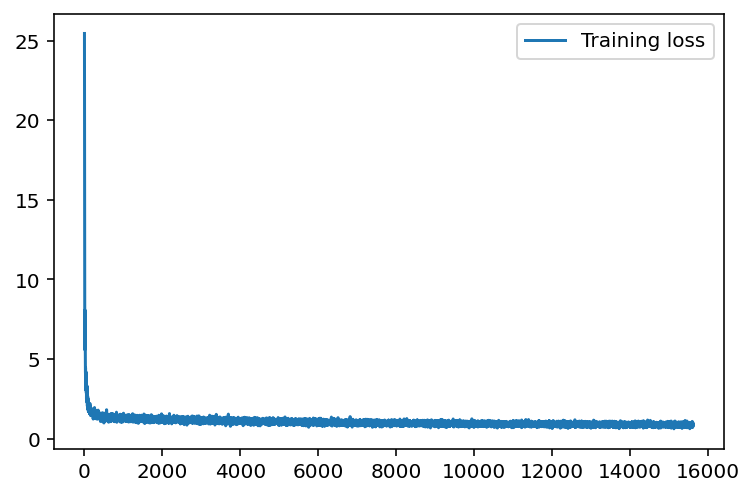

In [24]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

In [25]:
def get_tensors(loaded_graph):

    uid = loaded_graph.get_tensor_by_name("uid:0")
    user_gender = loaded_graph.get_tensor_by_name("user_gender:0")
    user_age = loaded_graph.get_tensor_by_name("user_age:0")
    user_job = loaded_graph.get_tensor_by_name("user_job:0")
    movie_id = loaded_graph.get_tensor_by_name("movie_id:0")
    movie_categories = loaded_graph.get_tensor_by_name("movie_categories:0")
    movie_titles = loaded_graph.get_tensor_by_name("movie_titles:0")
    targets = loaded_graph.get_tensor_by_name("targets:0")
    dropout_keep_prob = loaded_graph.get_tensor_by_name("dropout_keep_prob:0")
    lr = loaded_graph.get_tensor_by_name("LearningRate:0")
    #两种不同计算预测评分的方案使用不同的name获取tensor inference
#     inference = loaded_graph.get_tensor_by_name("inference/inference/BiasAdd:0")
    inference = loaded_graph.get_tensor_by_name("inference/ExpandDims:0") # 之前是MatMul:0 因为inference代码修改了 
    movie_combine_layer_flat = loaded_graph.get_tensor_by_name("movie_fc/Reshape:0")
    user_combine_layer_flat = loaded_graph.get_tensor_by_name("user_fc/Reshape:0")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference, movie_combine_layer_flat, user_combine_layer_flat

In [26]:
def rating_movie(user_id_val, movie_id_val):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
    
        # Get Tensors from loaded model
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference,_, __ = get_tensors(loaded_graph)  #loaded_graph
    
        categories = np.zeros([1, 18])
        categories[0] = movies.values[movieid2idx[movie_id_val]][2]
    
        titles = np.zeros([1, sentences_size])
        titles[0] = movies.values[movieid2idx[movie_id_val]][1]
    
        feed = {
              uid: np.reshape(users.values[user_id_val-1][0], [1, 1]),
              user_gender: np.reshape(users.values[user_id_val-1][1], [1, 1]),
              user_age: np.reshape(users.values[user_id_val-1][2], [1, 1]),
              user_job: np.reshape(users.values[user_id_val-1][3], [1, 1]),
              movie_id: np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
              movie_categories: categories,  #x.take(6,1)
              movie_titles: titles,  #x.take(5,1)
              dropout_keep_prob: 1}
    
        # Get Prediction
        inference_val = sess.run([inference], feed)  
    
        return (inference_val)

In [27]:
loaded_graph = tf.Graph()  #
movie_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, movie_combine_layer_flat, __ = get_tensors(loaded_graph)  #loaded_graph

    for item in movies.values:
        categories = np.zeros([1, 18])
        categories[0] = item.take(2)

        titles = np.zeros([1, sentences_size])
        titles[0] = item.take(1)

        feed = {
            movie_id: np.reshape(item.take(0), [1, 1]),
            movie_categories: categories,  #x.take(6,1)
            movie_titles: titles,  #x.take(5,1)
            dropout_keep_prob: 1}

        movie_combine_layer_flat_val = sess.run([movie_combine_layer_flat], feed)  
        movie_matrics.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [28]:
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

In [29]:
loaded_graph = tf.Graph()  #
users_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, __,user_combine_layer_flat = get_tensors(loaded_graph)  #loaded_graph

    for item in users.values:

        feed = {
            uid: np.reshape(item.take(0), [1, 1]),
            user_gender: np.reshape(item.take(1), [1, 1]),
            user_age: np.reshape(item.take(2), [1, 1]),
            user_job: np.reshape(item.take(3), [1, 1]),
            dropout_keep_prob: 1}

        user_combine_layer_flat_val = sess.run([user_combine_layer_flat], feed)  
        users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [30]:
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

In [1]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):

    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        #推荐您喜欢的电影
        probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 200])

        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
    #     print(sim.shape)
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    #     sim_norm = probs_norm_similarity.eval()
    #     print((-sim_norm[0]).argsort()[0:top_k])
    
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
      
        for val in (results):
            print(val)
            print(movies_orig[val])

        return results

In [2]:
recommend_your_favorite_movie(23, 10)

NameError: name 'tf' is not defined

In [33]:
def recommend_same_type_movie(movie_id_val, top_k = 20):
    
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        
        norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keep_dims=True))
        normalized_movie_matrics = movie_matrics / norm_movie_matrics

        #推荐同类型的电影
        probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        
        return results

In [ ]:
recommend_same_type_movie(23, 3)

INFO:tensorflow:Restoring parameters from ./save
您看的电影是：[23 'Assassins (1995)' 'Thriller']
以下是给您的推荐：
